In [1]:
# python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
import os
os.environ["OPENAI_API_KEY"]=os.environ["OPENAI_KEY"]

from agent.agents import agent_factory

In [2]:
def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
import requests

# img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
# image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
image = Image.open("/home/anxing/Pictures/test")

prompt="""Task: Put the phone on the right keyboard."""


In [4]:
agent = agent_factory("DetVLM")
plan_result = agent.plan(prompt, image)
plan_result

[{'score': 0.7769473195075989, 'bbox': [0.23465189337730408, 0.2637220621109009, 0.7102661728858948, 0.6178104877471924], 'box_name': 'laptop', 'objectness': 0.5868090987205505}, {'score': 0.5780084133148193, 'bbox': [0.5488576292991638, 0.4194495379924774, 0.7213863581418991, 0.4771123453974724], 'box_name': 'marker', 'objectness': 0.4647463262081146}, {'score': 0.3640248477458954, 'bbox': [0.10665766894817352, 0.305101215839386, 0.22806256264448166, 0.3380163572728634], 'box_name': 'marker', 'objectness': 0.282138854265213}, {'score': 0.640400767326355, 'bbox': [0.867664635181427, 0.4757044315338135, 1.1353318691253662, 0.6353553235530853], 'box_name': 'keyboard', 'objectness': 0.49831247329711914}, {'score': 0.5670104622840881, 'bbox': [0.2529042959213257, 0.33949708938598633, 0.5828403830528259, 0.4099958539009094], 'box_name': 'keyboard', 'objectness': 0.17921079695224762}, {'score': 0.37865185737609863, 'bbox': [0.5097126960754395, 0.4583472013473511, 0.6680401861667633, 0.534924

KeyError: 0

In [10]:
agent = agent_factory("SegVLM")
plan_result = agent.plan(prompt, image)
plan_result

PlanResult(success=True,
 error_message=None,
 plan_raw="```python\n# Robot code to place the red blocks into the green bowl\n\n# Pick the red block labeled with number 1\npick(regions[1])\n# Place the red block in the green bowl (orientation is arbitrary, assuming top-down)\nplace(regions[25], orientation='top-down')\n\n# Pick the red block labeled with number 30\npick(regions[30])\n# Place the red block in the green bowl\nplace(regions[25], orientation='top-down')\n\n# Pick the red block labeled with number 31\npick(regions[31])\n# Place the red block in the green bowl\nplace(regions[25], orientation='top-down')\n\n# Pick the red block labeled with number 12 (already in green bowl)\npick(regions[12])\n# Place the red block neatly in the green bowl if necessary\nplace(regions[25], orientation='top-down')\n```",
 masks=[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False

In [6]:
print(plan_result.plan_code)


# Define the regions for the red blocks and the green bowl
red_blocks = [regions[2], regions[1]]
green_bowl = regions[0]

# For each block, pick it up and place it in the green bowl
for block in red_blocks:
    pick(block)
    place(green_bowl, 'inside')



In [9]:
print(plan_result.plan_raw)

To complete the task, the robot should pick up each red block and place it inside the green bowl. We can see there are two red blocks, marked with numbers 30 and 12, which need to be placed in the green bowl marked with numbers 6, 25, 37, 36, and 38.

Here is the code to perform the task:

```python
# Define the regions for the red blocks and the green bowl
red_blocks = [regions[30], regions[12]]
green_bowl = regions[6]

# For each block, pick it up and place it in the green bowl
for block in red_blocks:
    pick(block)
    place(green_bowl, 'inside')
```

Run this code sequence to move the red blocks into the green bowl.


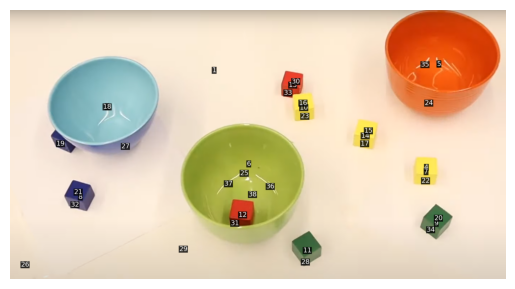

In [8]:
show_image(plan_result.annotated_image)